In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from coba.experiments.results import CustomResult

# Run Simulation

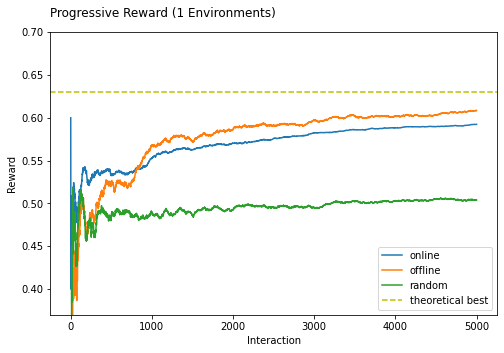

In [32]:
import coba as cb
import numpy as np
import matplotlib.pyplot as plt

from coba.environments.banditreplay import BanditReplay

class CustomEnvironment(cb.LambdaSimulation):
    def __init__(self, n_interactions = 1000):
        super().__init__(n_interactions, self.context, self.actions, self.rewards)
        self.r =cb. CobaRandom(1)

    def context(self, index: int):
        return {
            "feature_1": self.r.randoms(1)[0],
            "feature_2": self.r.randoms(1)[0],
            "feature_3": self.r.randoms(1)[0]
        }

    def actions(self, index: int, context):
        return [0, 1]

    def rewards(self, index: int, context, action) -> float:
        reward_probabilities_for_actions = np.clip([
            0.5 + 1.0 * (context["feature_1"] - 0.5) - 0.5 * (context["feature_2"] - 0.5),
            0.5
        ],a_min=0,a_max=1)

        return np.random.binomial(1, reward_probabilities_for_actions[action])

online_learners     = cb.VowpalSoftmaxLearner(features=[1, 'x', 'a', 'ax', 'axx'])
online_environments = cb.Environments(CustomEnvironment(5000)).shuffle(n=5)
online_logged       = cb.SimpleEvaluation(record=['context','actions','rewards','action','reward','probability','ope_loss'])
online_result       = cb.Experiment(online_environments, online_learners, evaluation_task=online_logged).run(quiet=True)

offline_learners     = [cb.VowpalOffPolicyLearner([1, 'x', 'a', 'ax', 'axx']), cb.RandomLearner()]
offline_environments = BanditReplay(online_result.interactions.to_pandas(),take=5000)
offline_result       = cb.Experiment(offline_environments, offline_learners, evaluation_task=online_logged).run(quiet=True)

plt.figure(figsize=(8,8))
online_result.plot_learners(labels=['online'],colors=[0],out=None)
offline_result.plot_learners(labels=['offline','random'],colors=[1],out=None)
plt.axhline(y = 0.63, color = 'y', linestyle = '--', label='theoretical best')
plt.legend()
plt.ylim(.37,.7)
plt.show()

In [11]:
offline_result.__class__ = CustomResult
offline_result.eval_metrics()


,learners,reward,probability,ope_loss,environment_variance
learner_id,,,,,
0,vw: --cb_adf --random_seed 1 --interactions a...,0.6094,0.9998,-0.301671,NaN
1,random: N/A,0.4966,0.5000,0.000000,NaN


In [12]:
online_result.__class__ = CustomResult
online_result.eval_metrics()

,learners,reward,probability,ope_loss,environment_variance
learner_id,,,,,
0,vw: --cb_explore_adf --softmax --lambda 10 --r...,0.58956,0.804522,-0.058131,0.000068
